In [1]:
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import pandas as pd

In [2]:
df = pd.read_excel("../Articles/MediaBiasGroup/labeled_dataset.xlsx")

C:\Users\dario\miniconda3\envs\similarNews\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
df = df[df["Label_bias"] != 'No agreement']

In [4]:
df.loc[df["Label_bias"]=="Non-biased", ["Label_bias"]] = 0
df.loc[df["Label_bias"]=="Biased", ["Label_bias"]] = 1

In [5]:
corpus = df["sentence"]

In [6]:
import nltk
import gensim
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

stopword_corpus = remove_stopwords(corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

cleaned_corpus = lemmatization(stopword_corpus)

In [8]:
de_tokenized = [' '.join(sentence) for sentence in cleaned_corpus]

In [9]:
df["cleaned_text"] = de_tokenized

In [10]:
test = df.iloc[:200,:]
train = df.iloc[200:,:]

In [11]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], 
                           dtype=tf.string, trainable=True)


In [12]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(40, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
])

# Compile model:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['binary_accuracy'])

In [13]:
history = model.fit(tf.convert_to_tensor(train["cleaned_text"]), tf.convert_to_tensor(train["Label_bias"].astype("category")), epochs=10)

Epoch 1/10
43/43 [==============================] - 13s 133ms/step - loss: 10.1328 - binary_accuracy: 0.5411
Epoch 2/10
43/43 [==============================] - 6s 133ms/step - loss: 5.7709 - binary_accuracy: 0.6358
Epoch 3/10
43/43 [==============================] - 6s 133ms/step - loss: 3.7934 - binary_accuracy: 0.5959
Epoch 4/10
43/43 [==============================] - 6s 134ms/step - loss: 2.6156 - binary_accuracy: 0.7920
Epoch 5/10
43/43 [==============================] - 6s 134ms/step - loss: 1.7680 - binary_accuracy: 0.9578
Epoch 6/10
43/43 [==============================] - 6s 142ms/step - loss: 1.3146 - binary_accuracy: 0.9889
Epoch 7/10
43/43 [==============================] - 6s 133ms/step - loss: 1.0132 - binary_accuracy: 0.9941
Epoch 8/10
43/43 [==============================] - 6s 141ms/step - loss: 0.8215 - binary_accuracy: 0.9956
Epoch 9/10
43/43 [==============================] - 6s 135ms/step - loss: 0.6848 - binary_accuracy: 1.0000
Epoch 10/10
43/43 [================

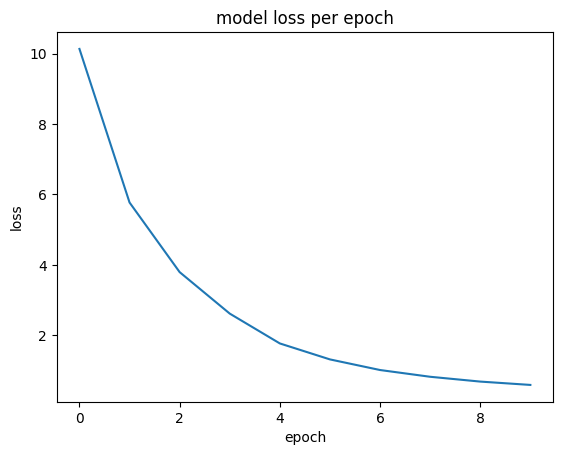

In [15]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [30]:
explicit = pd.read_csv("textblob_textblob.csv")

In [34]:
test_temp = explicit.iloc[:200,:]
true_test = test
true_test["explicit"] = test_temp["explicit"]
true_test = true_test[(true_test["explicit"] == "hard")]

C:\Users\dario\AppData\Local\Temp\ipykernel_5832\2039219086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_test["explicit"] = test_temp["explicit"]


In [35]:
test_loss, test_acc = model.evaluate(tf.convert_to_tensor(true_test["cleaned_text"]), tf.convert_to_tensor(true_test["Label_bias"].astype("category")), verbose=1)

2/2 [==============================] - 0s 11ms/step - loss: 0.8317 - binary_accuracy: 0.8140


In [17]:
export_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)


In [18]:
text_to_predict = ["It is the third time that Prime Minister Rishi Sunak has backed down in the face of rebellious backbenchers since taking power in October."]
text_to_predict = remove_stopwords(text_to_predict)
text_to_predict = lemmatization(text_to_predict)
text_to_predict = [' '.join(sentence) for sentence in text_to_predict]

predictions = export_model.predict(text_to_predict)
predictions

array([[0.5485208]], dtype=float32)